In [1]:
from matplotlib import pyplot as plt
import numpy as np
import random

import torch
import cmc_model
import metaworld_env


import context_changers

import dmc

import drqv2
import utils

import rl_model
import imageio

/home/rob0/miniconda3/envs/sharingan/lib/python3.8/site-packages/gym/spaces/box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [2]:
expert_frame_stack = 3
frame_stack = 1
action_repeat = 2

seed = 897
agent_seed = seed

episode_len = 40
context_camera_ids = [0]
learner_camera_id = 0
im_w = 64
im_h = 64
state_dim = 128
cam_id = random.choice(context_camera_ids)

num_eval_episodes = 1

utils.set_seed_everywhere(seed)

In [3]:
# task_name, xml_path, virl_id, rl_id = 'reacher_hard', 'domain_xmls/reacher.xml', 3, 4
# context_changer = context_changers.ReacherHardContextChanger()

task_name, env_name, cmc_id, rl_id = 'door_open', 'door-open-v2', 2, 4
context_changer = context_changers.NullContextChanger()

expert: drqv2.DrQV2Agent = drqv2.DrQV2Agent.load(f'exp_local/{task_name}/1/snapshot.pt')
expert.train(training=False)

encoder = cmc_model.CMCModel.load(f'cmc_exp_local/{task_name}/{cmc_id}/snapshot.pt').to(utils.device())
encoder.eval()

expert_env = metaworld_env.Env(env_name)
expert_env = dmc.wrap(expert_env, expert_frame_stack, action_repeat, episode_len=episode_len)

agent = rl_model.RLAgent.load(f'rl_exp_local/{task_name}/{rl_id}/snapshot.pt')
agent.eval()

/home/rob0/miniconda3/envs/sharingan/lib/python3.8/site-packages/gym/spaces/box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [4]:
def evaluate_agent():
    render_size = (480, 480)
    render_cam = cam_id
    expert_actions = []
    expert_frames = []
    expert_renders = []

    

    time_step = expert_env.reset()
    with utils.change_context(expert_env, context_changer):
        frame = expert_env.physics.render(im_w, im_h, camera_id=cam_id)
        frame = utils.rgb_to_lab(frame)
        expert_frames.append(frame)
        expert_renders.append(expert_env.physics.render(*render_size, camera_id=render_cam))

    with torch.no_grad():
        while not time_step.last():
            action = expert.act(time_step.observation, 1, eval_mode=True)
            time_step = expert_env.step(action)
            expert_actions.append(action)
            with utils.change_context(expert_env, context_changer):
                frame = expert_env.physics.render(im_w, im_h, camera_id=cam_id)
                frame = utils.rgb_to_lab(frame)
                expert_frames.append(frame)
                expert_renders.append(expert_env.physics.render(*render_size, camera_id=render_cam))
    expert_actions = np.array(expert_actions)

    expert_obs_sequence = torch.tensor(np.array(expert_frames).transpose((0, 3, 1, 2)), dtype=torch.float, device=utils.device())
    expert_state_sequence = encoder.encode_frame(expert_obs_sequence).detach().cpu().numpy()

    agent_actions = []
    agent_renders = []

    eval_env = metaworld_env.Env(env_name, im_w, im_h)
    eval_env = dmc.wrap(eval_env, frame_stack, action_repeat, episode_len=episode_len, to_lab=True)
    eval_env = dmc.ViRLEncoderStackWrapper(eval_env, expert, encoder,
                                                       expert_env,
                                                       context_camera_ids,im_w,
                                                       im_h, state_dim, frame_stack,
                                                       context_changer,
                                                       dist_reward=True, to_lab=True)

    time_step = eval_env.reset()

    agent_renders.append(eval_env.physics.render(*render_size, camera_id=render_cam))

    episode_return = time_step.reward
    while not time_step.last():
        with torch.no_grad(), utils.eval_mode(agent):
            state = torch.tensor(time_step.observation, device=utils.device(), dtype=torch.float)
            action = agent.act(state, 1, eval_mode=True)
        time_step = eval_env.step(action)
        episode_return += time_step.reward
        agent_actions.append(action)


        agent_renders.append(eval_env.physics.render(*render_size, camera_id=render_cam))
    agent_actions = np.array(agent_actions)

    expert_renders = np.array(expert_renders)
    agent_renders = np.array(agent_renders)

    renders = np.concatenate([expert_renders, agent_renders], axis=2)
    imageio.mimwrite(f'tmp/{task_name}_video.mp4', renders, 'mp4', fps=20)
    return episode_return, agent_actions, expert_actions, expert_state_sequence, np.array(eval_env.agent_seq_states), np.array(eval_env.agent_states), eval_env.expert_states, eval_env.expert_seq_states

## Evaluations

In [5]:
episode_return, agent_actions, expert_actions, e_state_seq, a_seq, a_state_seq, t_e_state_seq, t_e_seq = evaluate_agent()

Found 3 GPUs for rendering. Using device 0.


In [6]:
def encode_state_seq(state_seq):
    state_seq = torch.tensor(state_seq, dtype=torch.float, device=utils.device())
    z_seq = []
    with torch.no_grad():
        for i in range(state_seq.shape[0]):
            z_seq.append(encoder.encode_state_seq(state_seq[:i+1])[-1].cpu().numpy())
    z_seq = np.array(z_seq)
    return z_seq

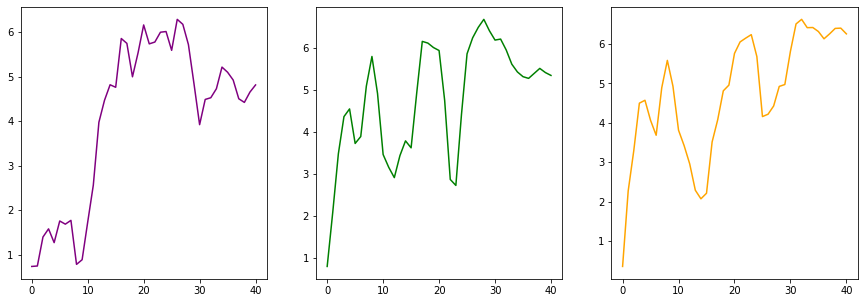

In [7]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(np.linalg.norm(t_e_state_seq - e_state_seq, axis=1), color='purple')
axes[1].plot(np.linalg.norm(e_state_seq - a_state_seq, axis=1), color='green')
axes[2].plot(np.linalg.norm(t_e_state_seq - a_state_seq, axis=1), color='orange')


plt.show()

In [8]:
np.linalg.norm(t_e_state_seq - e_state_seq, axis=1).sum()

166.54817

In [9]:
np.linalg.norm(t_e_state_seq - a_state_seq, axis=1).sum()

194.27094

In [10]:
e_seq = encode_state_seq(e_state_seq)

In [11]:
t_e_state_seq.shape

(41, 128)

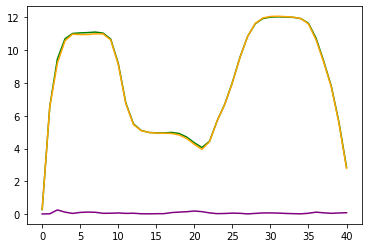

In [12]:
# plt.figure(figsize=(15, 5))

plt.plot(np.linalg.norm(t_e_seq - e_seq, axis=1), color='purple')
plt.plot(np.linalg.norm(e_seq - a_seq, axis=1), color='green')
plt.plot(np.linalg.norm(t_e_seq - a_seq, axis=1), color='orange')

plt.show()

In [13]:
np.linalg.norm(t_e_seq - e_seq, axis=1)[1:].sum()

2.9257956

In [14]:
np.linalg.norm(t_e_seq - a_seq, axis=1)[1:].sum()

332.3152

In [15]:
e_seq[-1]

array([  8.742401  ,  -4.49512   ,   6.7168107 ,   5.776457  ,
        -8.664802  ,   7.9194417 ,   5.7353992 ,   8.870883  ,
        -3.4775794 ,   6.1059823 ,   3.0926213 ,   6.323736  ,
        -5.1520395 ,  -5.7995996 ,   2.8326523 ,  -7.780036  ,
        -6.630458  ,   5.6886306 ,   2.9270766 ,   6.0102973 ,
         6.018804  ,  -5.55788   ,  -3.4912252 ,   5.656953  ,
        -3.377711  ,   5.423179  ,   6.462947  ,  -5.7196183 ,
         6.460311  ,  -4.870545  ,  -8.215642  ,  -5.659626  ,
        -5.2425222 ,   5.4232774 , -11.689209  ,  -0.1255041 ,
        -6.5483236 ,   0.34104645,   4.756819  ,  -2.892199  ,
        -3.2020211 ,   3.1885817 ,  -5.9357786 ,  -0.86053693,
        -4.136155  ,   6.8377886 ,   4.334624  ,   6.6276264 ,
        -6.7847133 ,  -4.9659595 ,   1.3028487 ,   6.1159096 ,
        -4.953039  ,   1.3660059 ,  -1.1178031 ,  -3.6309805 ,
         7.867197  ,   5.9058003 ,  -6.689775  ,   7.7634263 ,
         6.9503584 ,   2.139654  ,  -4.0624995 ,   7.42

In [16]:
a_seq[-1]

array([  8.962039  ,  -4.651609  ,   7.1290216 ,   5.595417  ,
        -8.486609  ,   8.066858  ,   5.3015    ,   8.342544  ,
        -3.2881694 ,   5.7739124 ,   3.483581  ,   6.188843  ,
        -5.131013  ,  -5.880916  ,   2.8273041 ,  -7.989746  ,
        -6.587256  ,   5.993829  ,   2.7095382 ,   5.659047  ,
         5.883126  ,  -5.3799667 ,  -3.5281978 ,   5.5735517 ,
        -3.430886  ,   5.0334735 ,   6.305044  ,  -5.9868016 ,
         6.6010394 ,  -4.493666  ,  -7.7672734 ,  -5.3231764 ,
        -5.2136207 ,   5.2768183 , -12.522626  ,  -0.22875327,
        -6.309162  ,   0.3792358 ,   4.8674507 ,  -2.7247872 ,
        -3.3440816 ,   3.0035512 ,  -5.5889106 ,  -0.7985757 ,
        -4.1424313 ,   6.82072   ,   4.377038  ,   6.762917  ,
        -6.459985  ,  -4.8923707 ,   1.618865  ,   6.5029078 ,
        -4.698036  ,   1.206056  ,  -0.95061105,  -3.288407  ,
         7.4534364 ,   5.604515  ,  -6.8473387 ,   8.120766  ,
         7.0606155 ,   2.4192607 ,  -4.196768  ,   7.12